In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='facemo.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('facemo.zip')
f.keys()
!unzip facemo.zip

In [2]:
gpus = tf.config.list_logical_devices('GPU') 
stg=tf.distribute.MirroredStrategy(gpus)

In [3]:
import cv2
import os
from tqdm import tqdm

folder_dir = '/content/facemo/images/train'
SIZE = 75
DOWNSAMPLE_RATIO = 4
JPEG_QUALITY = 100

total_files = sum(len(files) for _, _, files in os.walk(folder_dir))

with tqdm(total=total_files, desc="Processing Images") as pbar:
    for folder in os.listdir(folder_dir):
        for file in os.listdir(os.path.join(folder_dir, folder)):
            if file.endswith("jpg"):
                image_path = os.path.join(folder_dir, folder, file)
                img = cv2.imread(image_path)
                img_resized = cv2.resize(img, (SIZE,SIZE))
                cv2.imwrite(image_path, img_resized)
                pbar.update(1)
            else:
                continue

Processing Images: 100%|██████████| 2827/2827 [00:01<00:00, 2615.38it/s]


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [5]:
batch_size = 32
picture_size = (75, 75)
train_set = tf.keras.utils.image_dataset_from_directory(
    directory=folder_dir,
    shuffle=True,
    image_size=picture_size,
    batch_size=batch_size,
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed = 22
)

validation_set = tf.keras.utils.image_dataset_from_directory(
    directory=folder_dir,
    shuffle=True,
    image_size=picture_size,
    batch_size=batch_size,
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed = 22
)


Found 2827 files belonging to 5 classes.
Using 2262 files for training.
Found 2827 files belonging to 5 classes.
Using 565 files for validation.


In [9]:
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomTranslation, RandomFlip, RandomZoom
from tensorflow.keras.optimizers import Adam,SGD,RMSprop
from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import shutil
import random
import matplotlib.pyplot as plt

no_of_classes = 5

with stg.scope():
    img_augmentation = Sequential(
    [
        RandomRotation(factor=0.2),
        RandomTranslation(height_factor=0.1, width_factor=0.1),
        RandomZoom(height_factor=0.2)
    ],
    name="img_augmentation"
    )

    base_model = Xception(weights="imagenet", input_shape=(SIZE, SIZE, 3), include_top=False)
    base_model.trainable = False
    inputs = Input(shape=(SIZE, SIZE, 3))
    x = img_augmentation(inputs)
    outputs = base_model(x)

    x = GlobalAveragePooling2D()(outputs)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(32, activation='relu')(x)
    predictions = Dense(no_of_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=predictions)
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(lr=0.001),
        metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 75, 75, 3)]       0         
                                                                 
 img_augmentation (Sequentia  (None, 75, 75, 3)        0         
 l)                                                              
                                                                 
 xception (Functional)       (None, 3, 3, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0   

In [10]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 factor=0.1,
                                 patience=2,
                                 verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',
                                patience=5,
                                verbose=1)

callbacks = [lr_scheduler, early_stopping]


In [15]:
import tensorflow as tf

history = model.fit(train_set, epochs=100, validation_data=validation_set, callbacks=callbacks, 
                    steps_per_epoch=len(train_set), validation_steps=len(validation_set))


Epoch 1/100
71/71 [==============================] - 2s 34ms/step - loss: 1.5975 - accuracy: 0.2613 - val_loss: 1.5954 - val_accuracy: 0.2619 - lr: 1.0000e-10
Epoch 2/100
71/71 [==============================] - 2s 32ms/step - loss: 1.6048 - accuracy: 0.2613 - val_loss: 1.5954 - val_accuracy: 0.2619 - lr: 1.0000e-10
Epoch 3/100
69/71 [============================>.] - ETA: 0s - loss: 1.5989 - accuracy: 0.2613
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.
71/71 [==============================] - 3s 37ms/step - loss: 1.5989 - accuracy: 0.2613 - val_loss: 1.5954 - val_accuracy: 0.2619 - lr: 1.0000e-10
Epoch 4/100
71/71 [==============================] - 2s 32ms/step - loss: 1.5976 - accuracy: 0.2608 - val_loss: 1.5954 - val_accuracy: 0.2619 - lr: 1.0000e-11
Epoch 5/100
71/71 [==============================] - ETA: 0s - loss: 1.5968 - accuracy: 0.2622
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-12.
71/71 [===========================

In [16]:
test_loss, test_acc = model.evaluate(validation_set)
print('Test accuracy:', test_acc)

18/18 [==============================] - 24s 27ms/step - loss: 1.5954 - accuracy: 0.2619
Test accuracy: 0.2619469165802002


0 = Angry
1 = Happy
2 = Neutral
3 = Sad
4 = Surprise
1/1 [==============================] - 1s 1s/step


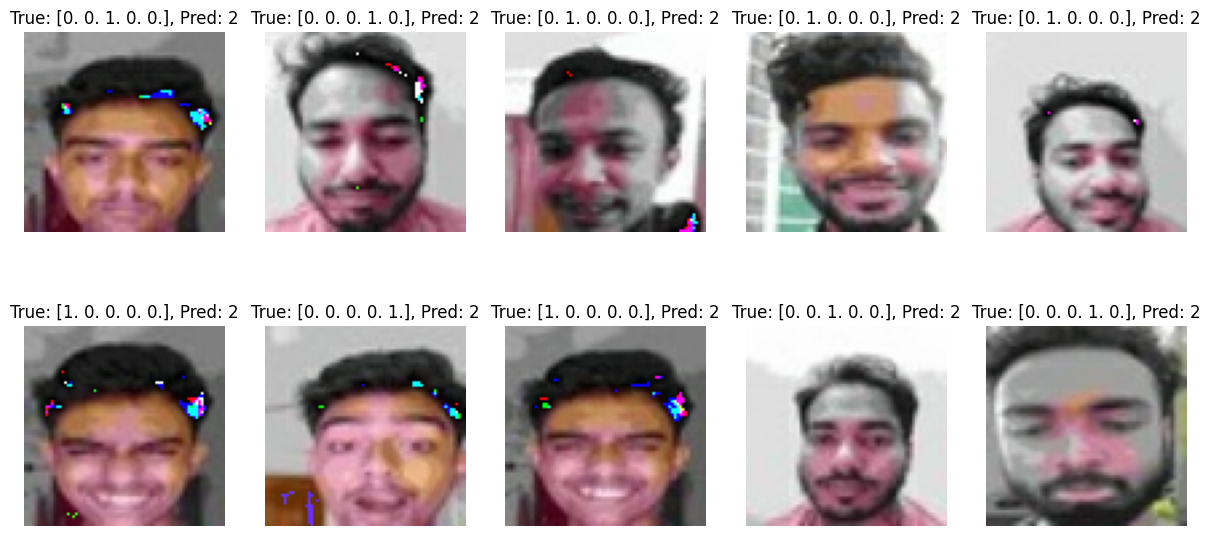

In [13]:
import numpy as np
import matplotlib.pyplot as plt

e = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']
for i in range(len(e)):
    print(i, "=", e[i])

test_batch = next(iter(validation_set))
images = test_batch[0][:10].numpy()
true_labels = test_batch[1][:10]

pred_probs = model.predict(images)
pred_labels = np.argmax(pred_probs, axis=1)

fig, axs = plt.subplots(2, 5, figsize=(15, 7))
axs = axs.flatten()

for i in range(len(images)):
    img = (images[i] * 255).astype(np.uint8)
    img = 255- img
    axs[i].imshow(img)
    axs[i].set_title(f'True: {true_labels[i]}, Pred: {pred_labels[i]}')
    axs[i].axis('off')

plt.show()
